In [1]:
from data_prep_utils import *
import matplotlib.pyplot as plt
from datetime import datetime
from tabpfn_new import priors, encoders
from tabpfn_new.scripts.model_configs import *
from tabpfn_new.scripts.model_builder import get_forest_prior_hyperparameters, get_mlp_prior_hyperparameters, get_model
from tabpfn.utils import get_uniform_single_eval_pos_sampler
from utils import get_dataloader
device = "cpu"

In [2]:
def reload_config(prior_type='forest', config_type='causal', task_type='binary', longer=0):
    config = get_prior_config(config_type=config_type)
    
    config['prior_type'] = prior_type
    
    model_string = ''
    
    config['epochs'] = 12000
    config['recompute_attn'] = True

    config['max_num_classes'] = 10
    config['num_classes'] = uniform_int_sampler_f(2, config['max_num_classes'])
    config['balanced'] = False
    model_string = model_string + '_multiclass'
    
    model_string = model_string + '_'+datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    
    return config, model_string

In [3]:
def dl_from_config(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=0)
    dl = dl_class(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return dl

                                     
def get_sample(dl):
    (style, x, y), _, _ =  next(iter(dl))
    return x, y
    
def plot_grid(dl, hyperparameters, rows=8, cols=6):
    fig, axes = plt.subplots(rows, cols, figsize=(20,15))
    class_assigner = priors.flexible_categorical.BalancedBinarize()#priors.flexible_categorical.MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    for ax in axes.flatten():
        x2, b = get_sample(dl)
        #b = class_assigner(b)
        i1, i2 = np.random.choice(x2.shape[2], size=(2,), replace=False)
        ax.scatter(x2[:, 0, i1], x2[:, 0, i2], c=b, s=1.5, cmap="bwr")

def remove_zero_features(x):
    x = x[:,:,torch.where(torch.sum(torch.abs(x), dim=0)>0,1,0)]
    return x

def plot_feature_combinations(dl, hyperparameters, num_plots=10):
    fig = plt.figure(figsize=(20,15))
    x2, b = get_sample(dl)
    #x2 = remove_zero_features(x2)
    #class_assigner = priors.flexible_categorical.BalancedBinarize()#MulticlassRank(hyperparameters['num_classes'], ordered_p=hyperparameters['output_multiclass_ordered_p'])
    #b = class_assigner(b)
    n_feat = num_plots#hyperparameters["max_features"]
    for i in range(n_feat-1):
        for j in range(n_feat):
            if(j>i) :
                ax = plt.subplot2grid((n_feat-1, n_feat-1), (i,j-1))
                #ax.xaxis.set_ticklabels([]) 
                #ax.yaxis.set_ticklabels([])
                plt.scatter(x2[:,0,i],x2[:,0,j],c=b, s=1.5, cmap="bwr")
    
    fig.show()

In [4]:
prior_type = 'mlp'
config, model_string = reload_config(prior_type, longer=1)

config['differentiable'] = True
config['flexible'] = True
config['bptt_extra_samples'] = None

# diff
config['output_multiclass_ordered_p'] = 0.0
del config['differentiable_hyperparameters']['output_multiclass_ordered_p']



config['sampling'] = 'normal' # vielleicht schlecht?
del config['differentiable_hyperparameters']['sampling']

config['pre_sample_causes'] = True
# end diff

config['multiclass_loss_type'] = 'nono' # 'compatible'
config['normalize_to_ranking'] = False # False

config['categorical_feature_p'] = 0 # diff: .0

# turn this back on in a random search!?
config['nan_prob_no_reason'] = .0
config['nan_prob_unknown_reason'] = .0 # diff: .0
config['set_value_to_nan'] = .0 # diff: 1.

config['normalize_with_sqrt'] = False

config['new_mlp_per_example'] = True
config['prior_mlp_scale_weights_sqrt'] = True
config['batch_size_per_gp_sample'] = None

config['normalize_ignore_label_too'] = False

config['differentiable_hps_as_style'] = False
config['max_eval_pos'] = 1000

config['random_feature_rotation'] = True
config['rotate_normalized_labels'] = True

config["mix_activations"] = True # False heisst eig True

config['emsize'] = 512
config['nhead'] = config['emsize'] // 128
config['bptt'] = 1024+128
config['canonical_y_encoder'] = True

    
config['aggregate_k_gradients'] = 1
config['batch_size'] = 1*config['aggregate_k_gradients']
config['num_steps'] = 1//config['aggregate_k_gradients']
config['epochs'] = 1

config['total_available_time_in_s'] = None #60*60*22 # 22 hours for some safety...

config['train_mixed_precision'] = True
config['efficient_eval_masking'] = True

# mlp params
config['is_causal'] = True
config['num_causes'] = 5
config['prior_mlp_hidden_dim'] = 50
config['num_layers'] = 4
config['noise_std'] = 0.05
config['init_std'] = 0.05
config['y_is_effect'] = True
config['pre_sample_weights'] = True
config['prior_mlp_dropout_prob'] = 0
config['pre_sample_causes'] = True
config["prior_mlp_activations"] = torch.nn.ReLU
config["block_wise_dropout"] = True
config["sort_features"] = False
config["in_clique"] = False

# general data params
config['balanced'] = True
config['max_num_classes'] = 2
config['max_features'] = 100
config['num_features_used'] = 100

config['num_classes'] = 2

config['no_encoder'] = False
config['normalize_to_ranking'] = False # False
config['normalize_with_sqrt'] = False
config['normalize_ignore_label_too'] = False
config["normalize"] = False
config['num_classes'] = 2
config["balanced"] = False
config['multiclass_type'] = 'imbalanced_binarize'


config_sample = evaluate_hypers(config)



In [5]:
#dl = dl_from_config(config_sample, prior_hyperparameters)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]

Using style prior: True
Using cpu:0 device
Using a Transformer with 25.81 M parameters


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


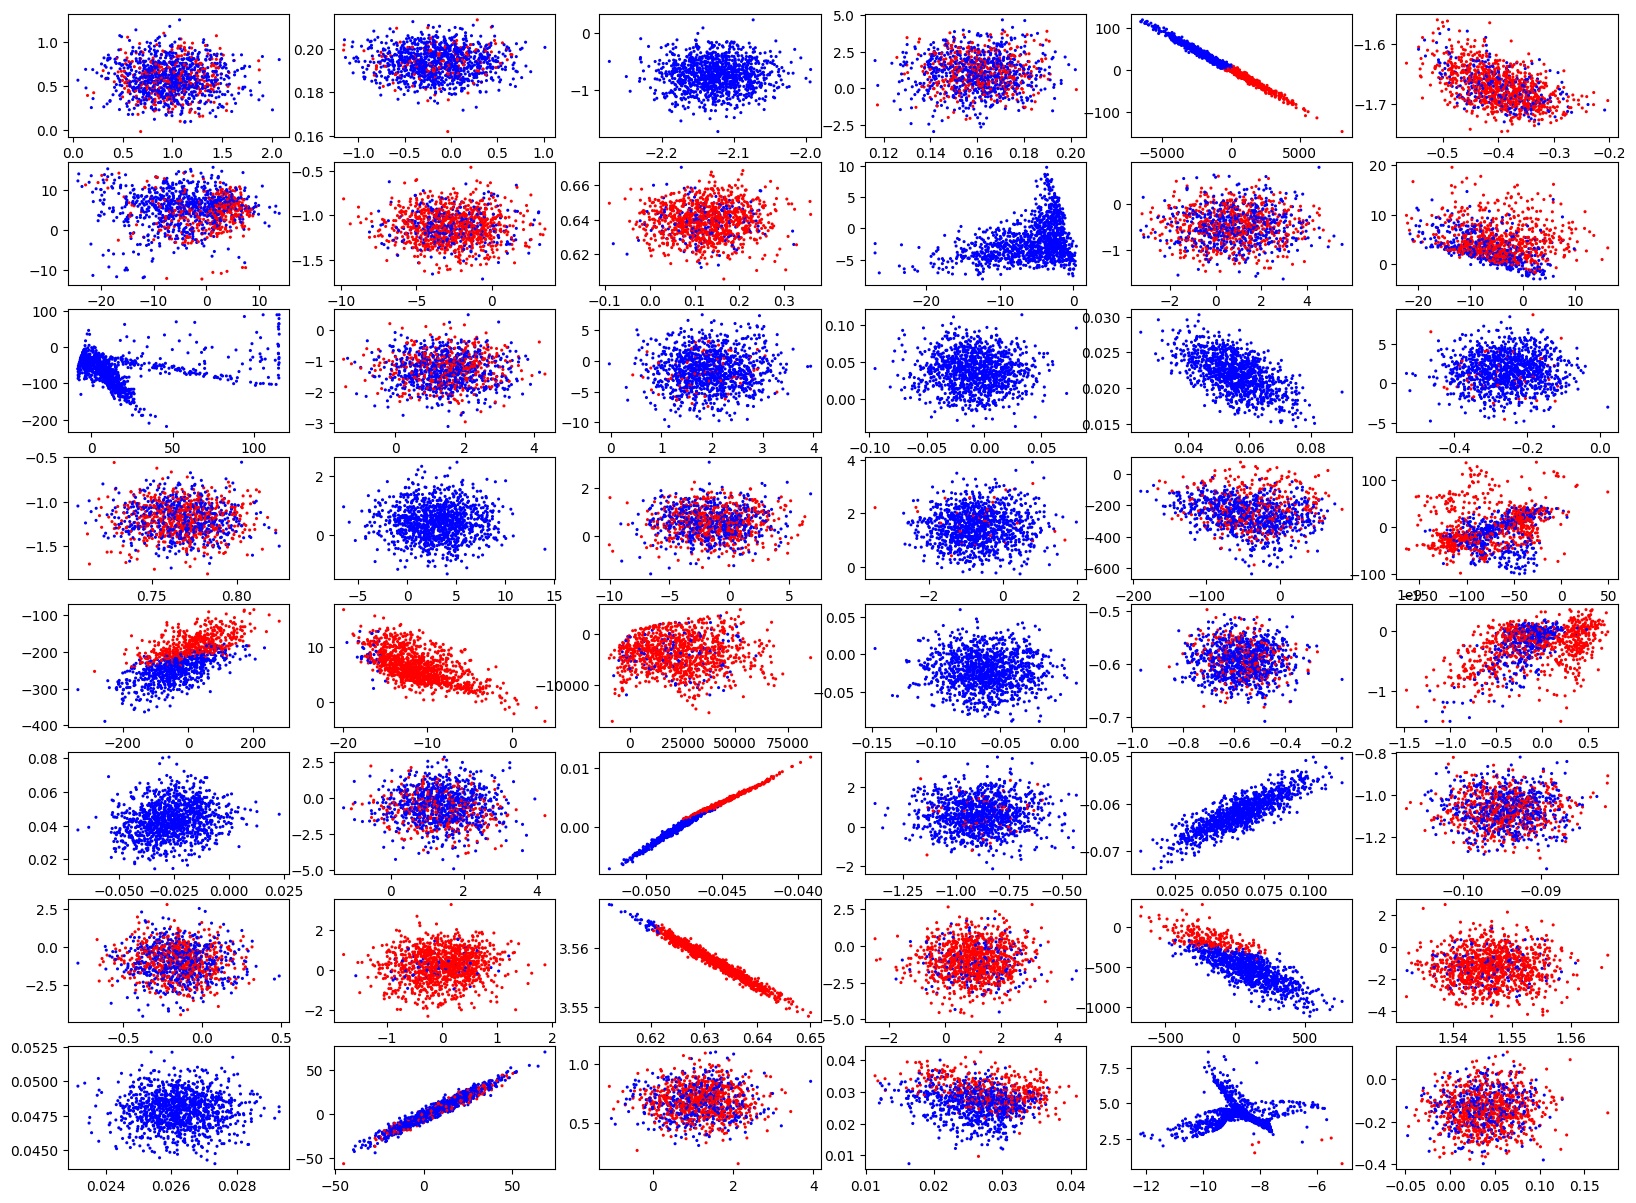

In [6]:
plot_grid(dl,config_sample)

C:\Users\lenna\AppData\Local\Temp\ipykernel_15300\1204246749.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


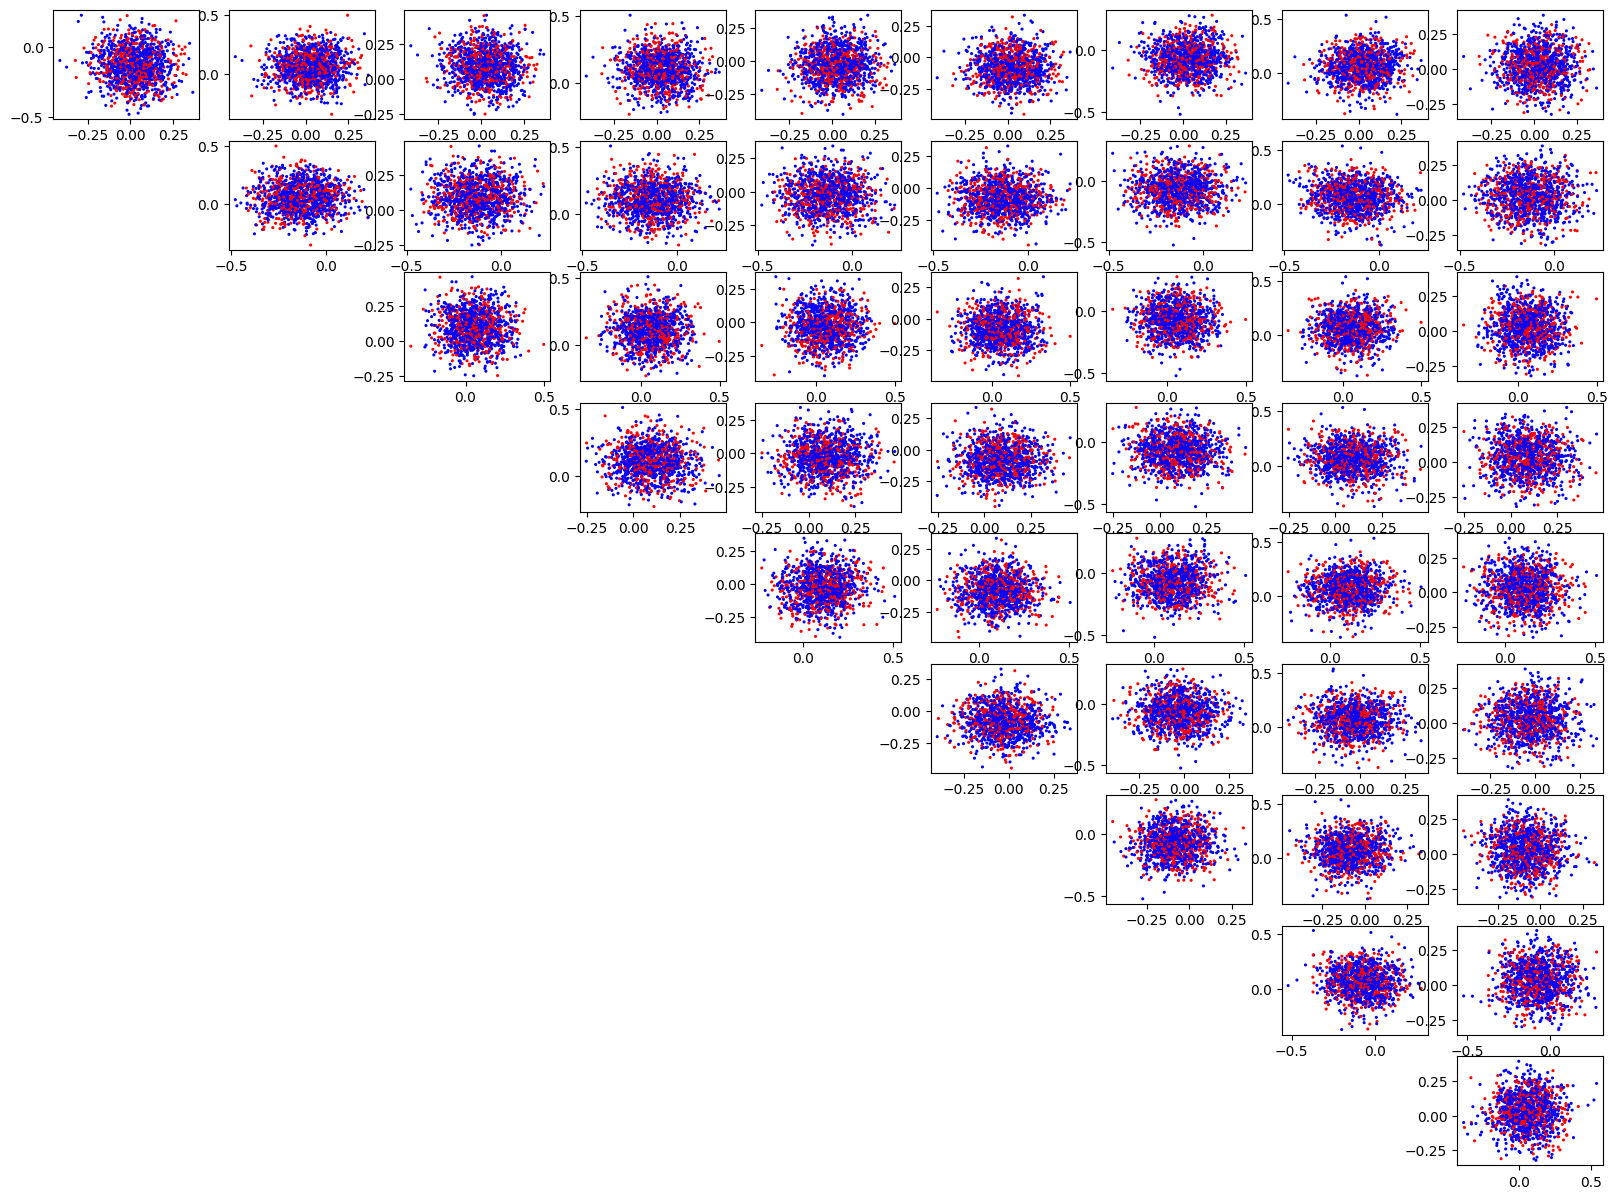

In [7]:
plot_feature_combinations(dl,config_sample)

C:\Users\lenna\AppData\Local\Temp\ipykernel_15300\1204246749.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


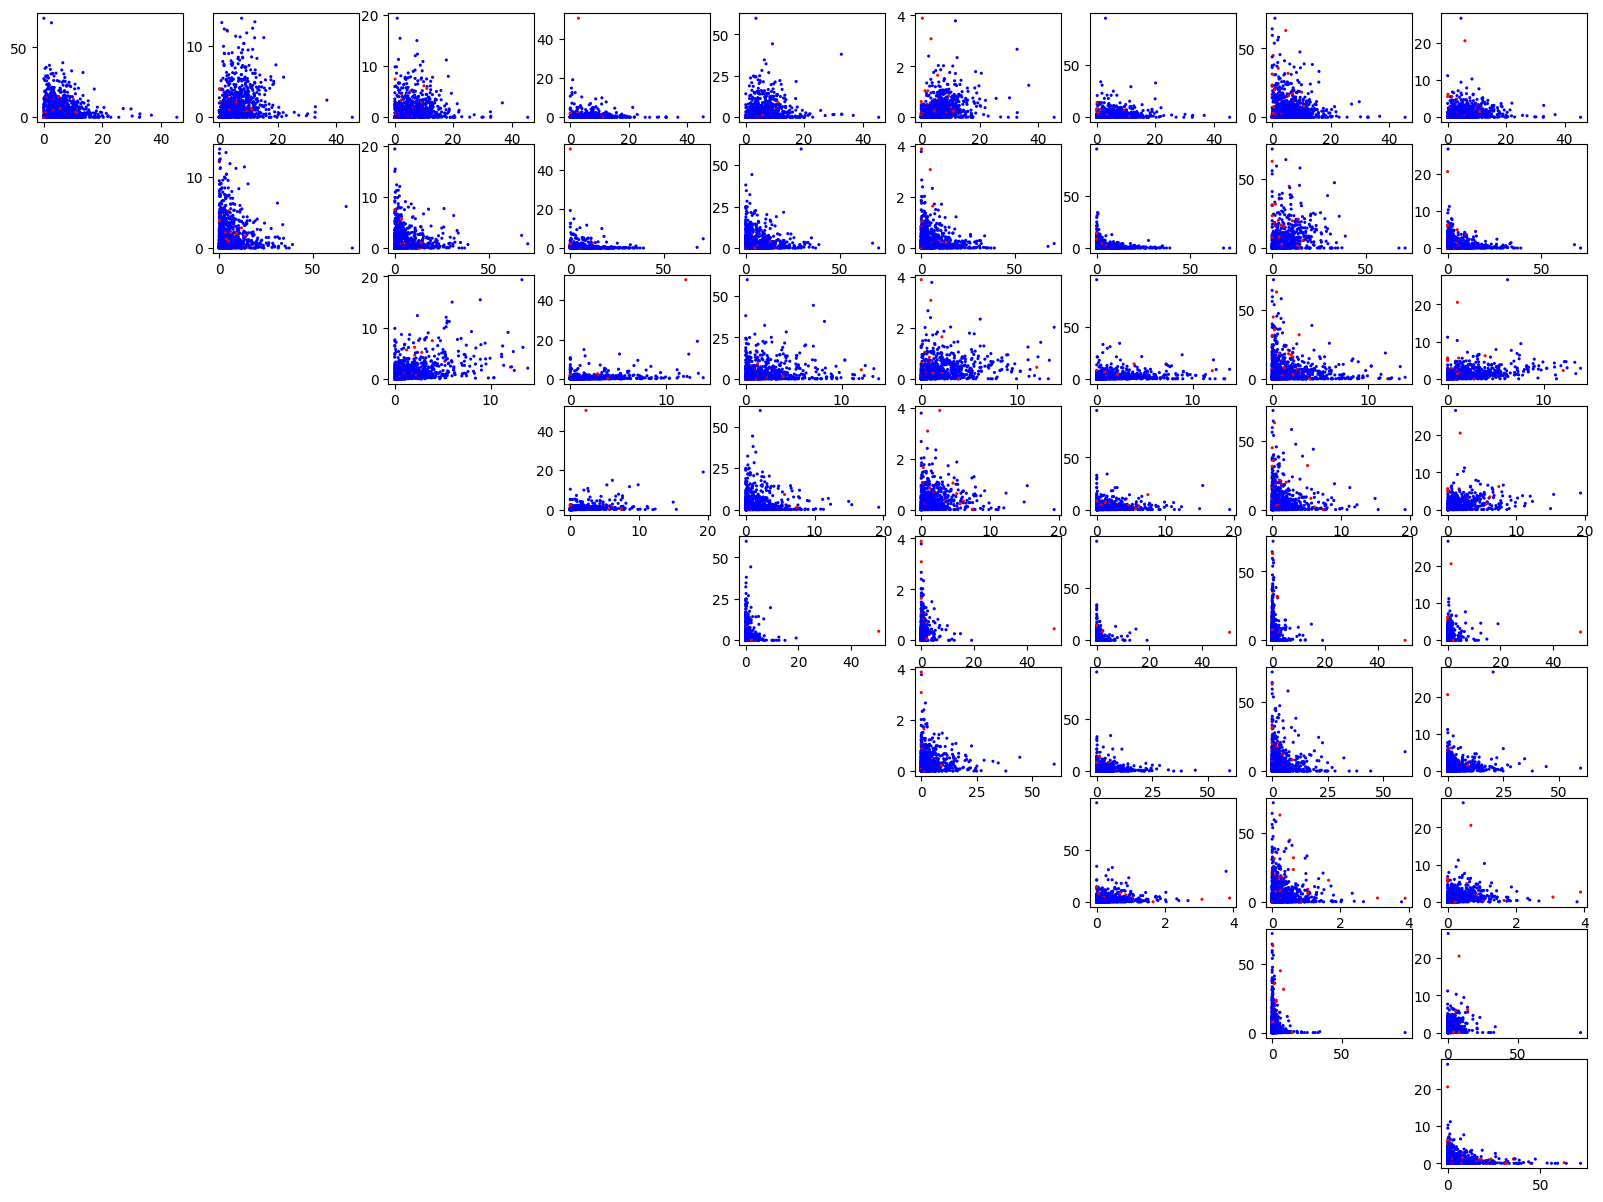

In [8]:
from torch.utils.data import DataLoader
class MicroDL(DataLoader):
    def __init__(self, path=None):
        data, labels = get_microbiome(path)
        data = top_non_zero(data)
        data, labels = unison_shuffled_copies(data, labels)
        self.data = data
        self.labels = labels

    def __len__(self):
        return 100
        
    def get_perm(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return (None, np.expand_dims(self.data[indices], axis=1), np.expand_dims(self.labels[indices],axis=1)), None, None
        
    def __iter__(self):
        indices = np.random.permutation(self.data.shape[0])[:1000]
        return iter(self.get_perm() for _ in range(100))
path = "datasets/data_all.csv"
dl = MicroDL(path)
#plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [27]:
config['differentiable'] = False
config['flexible'] = True

# forest params
config["min_features"] = 100
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 2
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False
config["data_sample_func"] = "zinb"
config["comp"] = True

config["balanced"] = True
config["prior_type"] = "forest"

Using style prior: False
Using cpu:0 device
Using a Transformer with 25.81 M parameters


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\lenna\AppData\Local\Temp\ipykernel_12328\1204246749.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


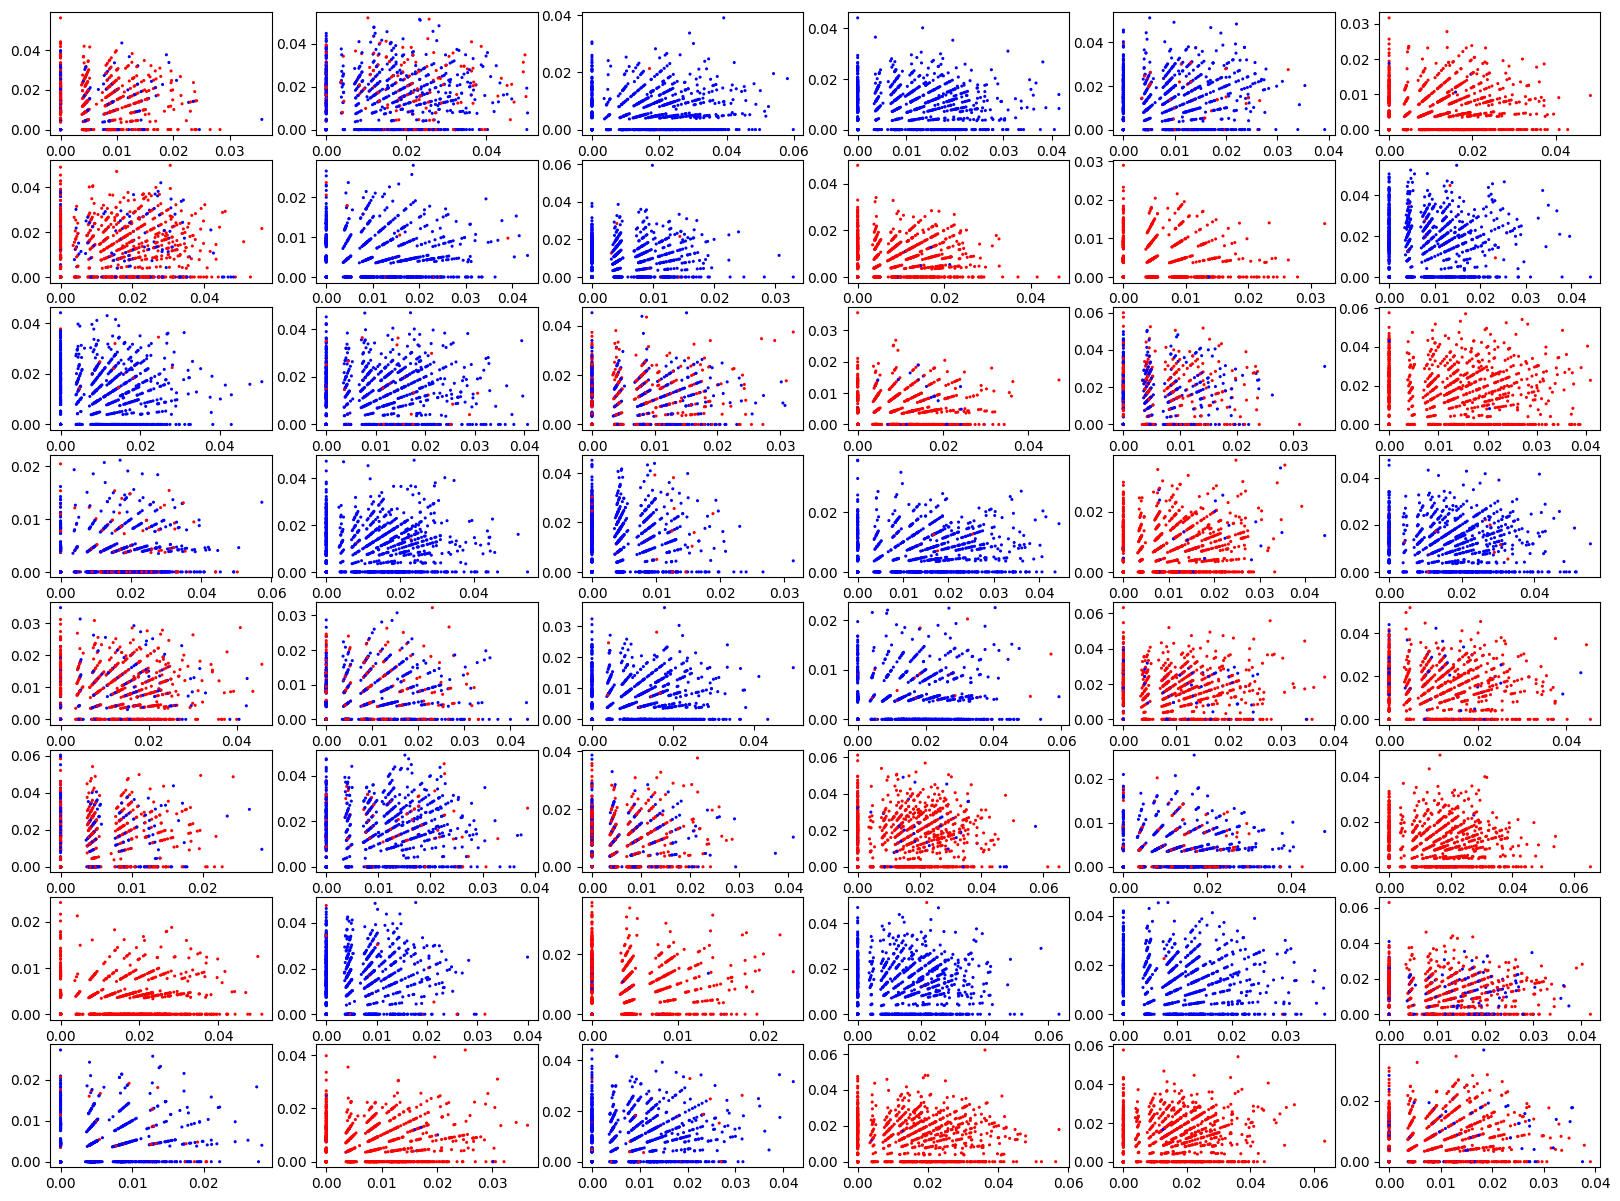

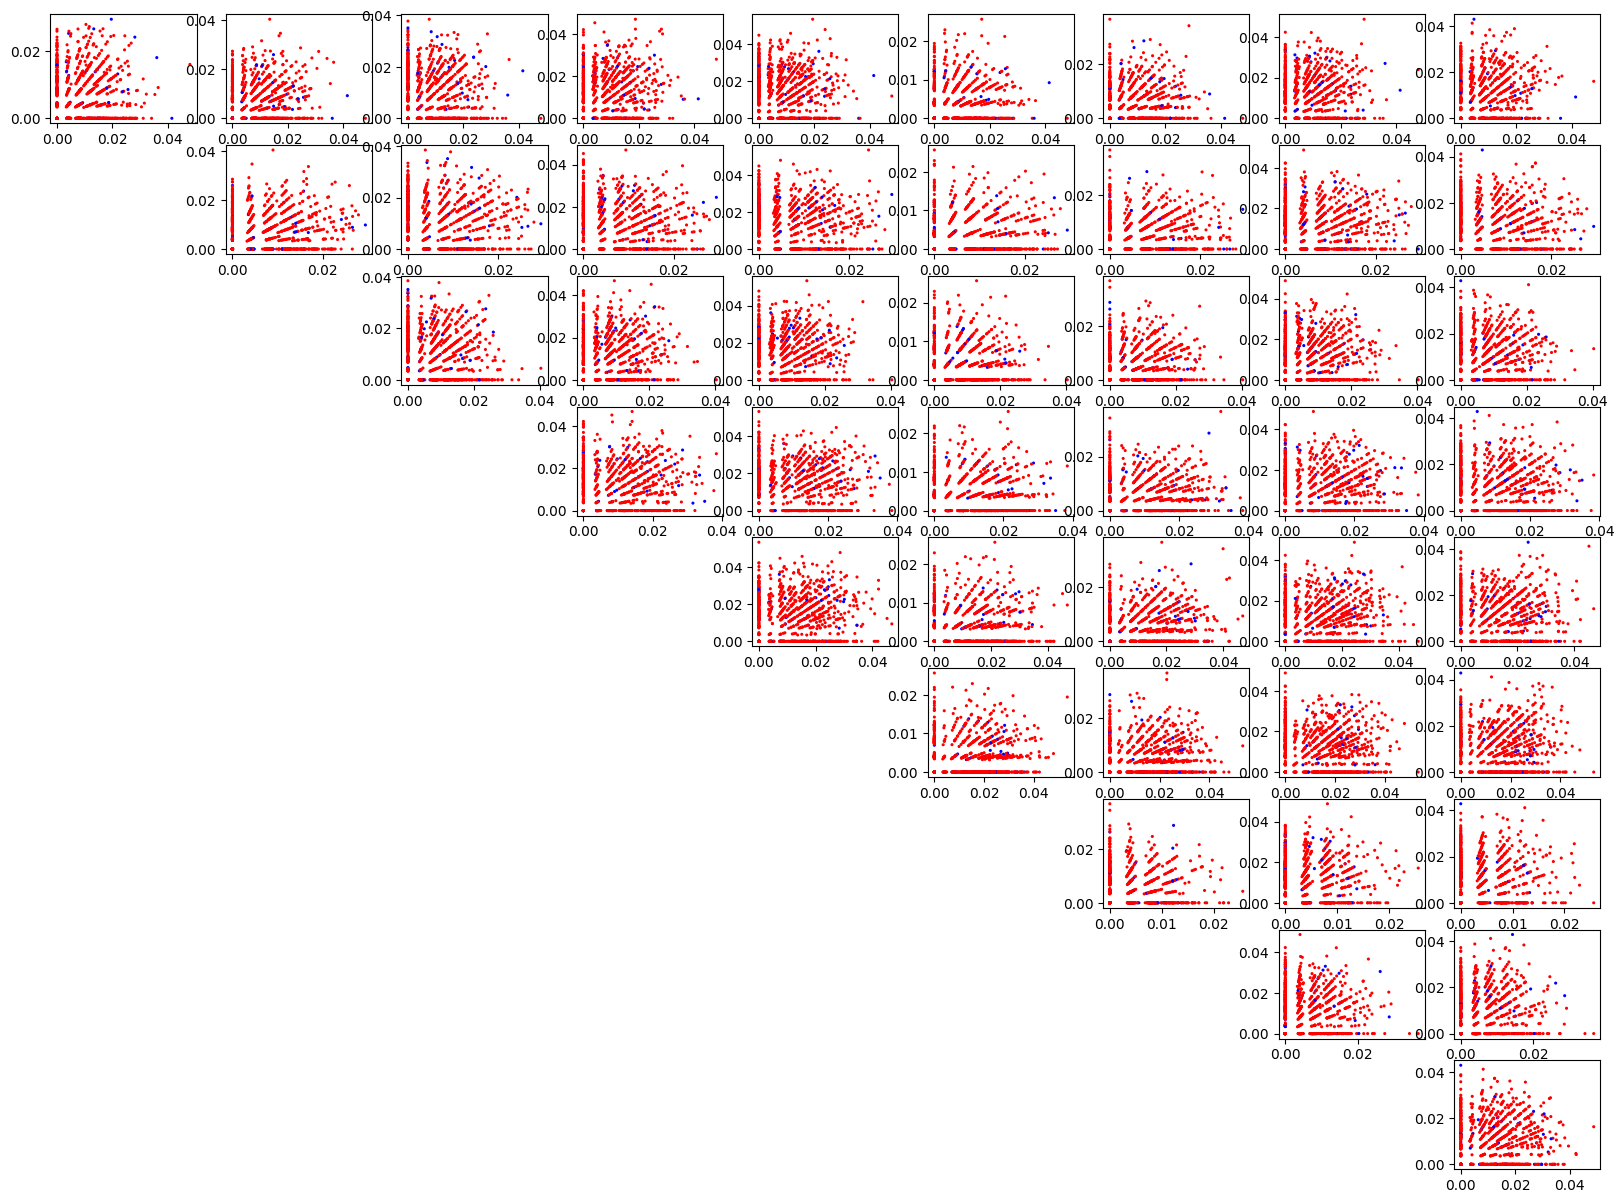

In [6]:
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]
plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

Using style prior: False
Using cpu:0 device
Using a Transformer with 25.81 M parameters


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\amp\grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\lenna\AppData\Local\Temp\ipykernel_12328\1204246749.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


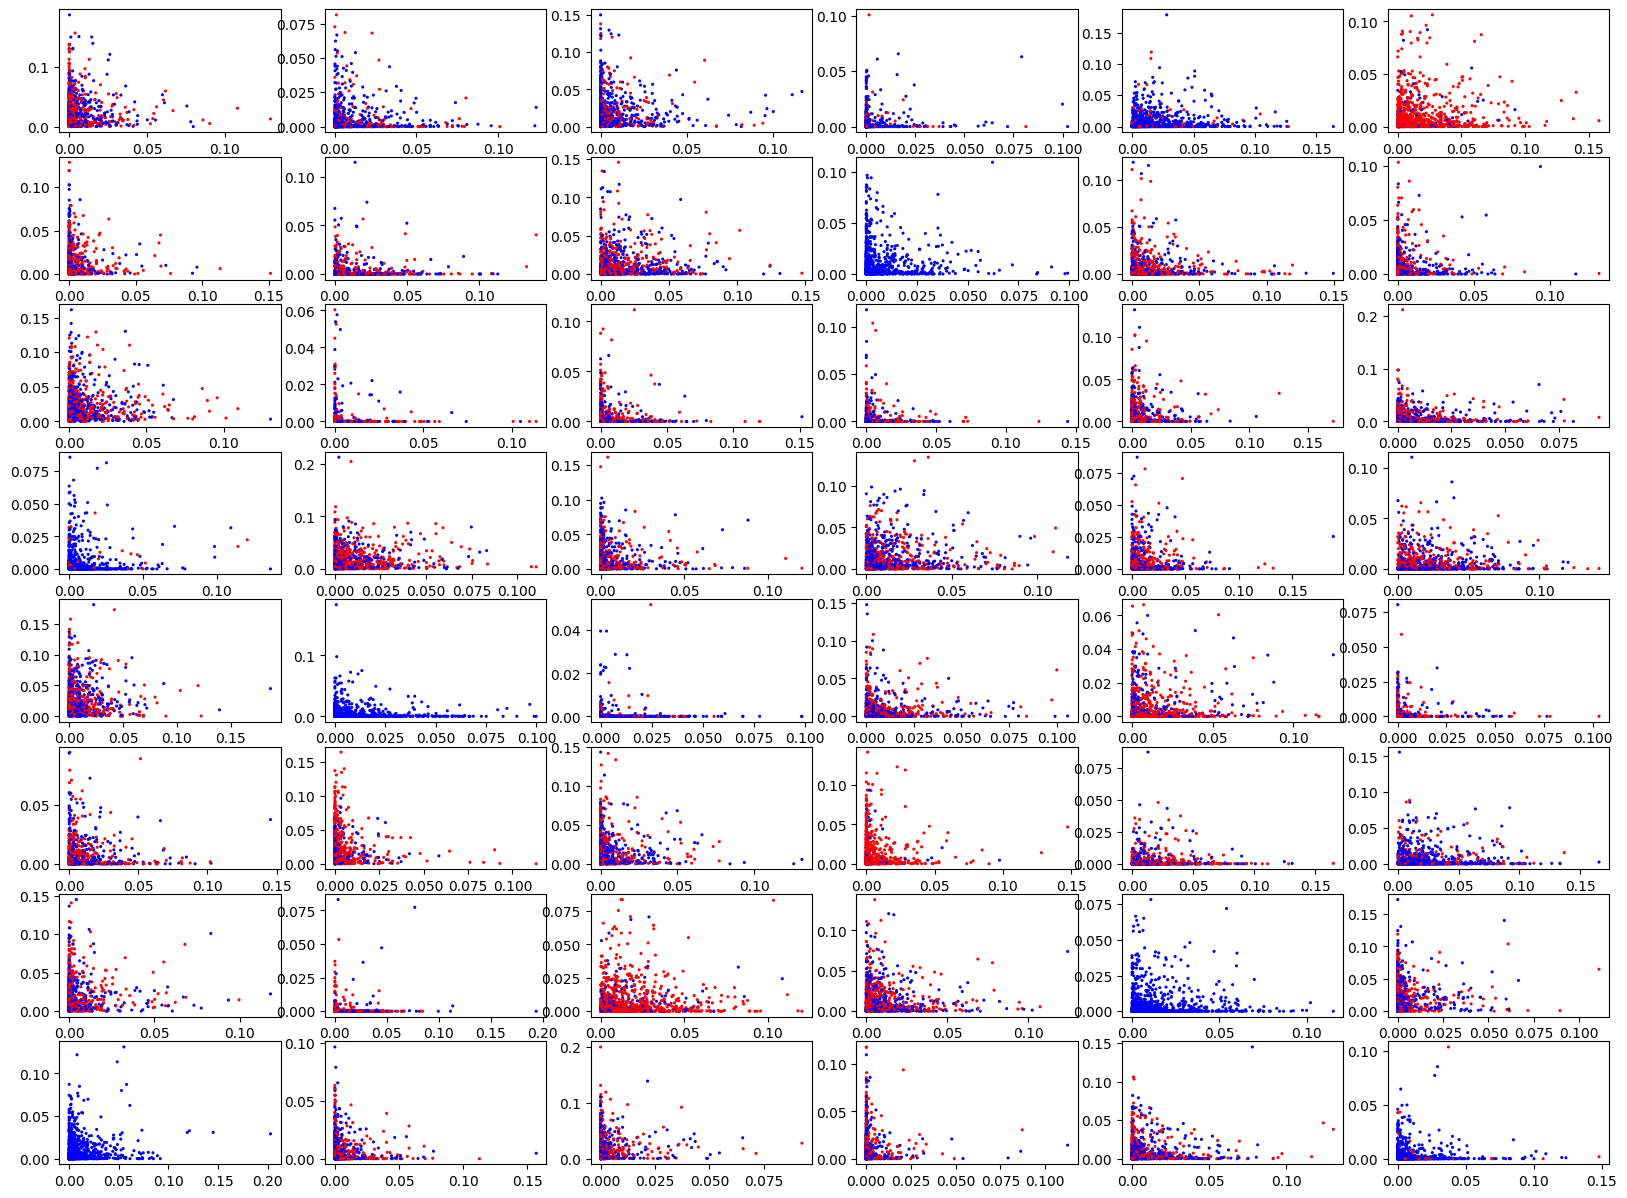

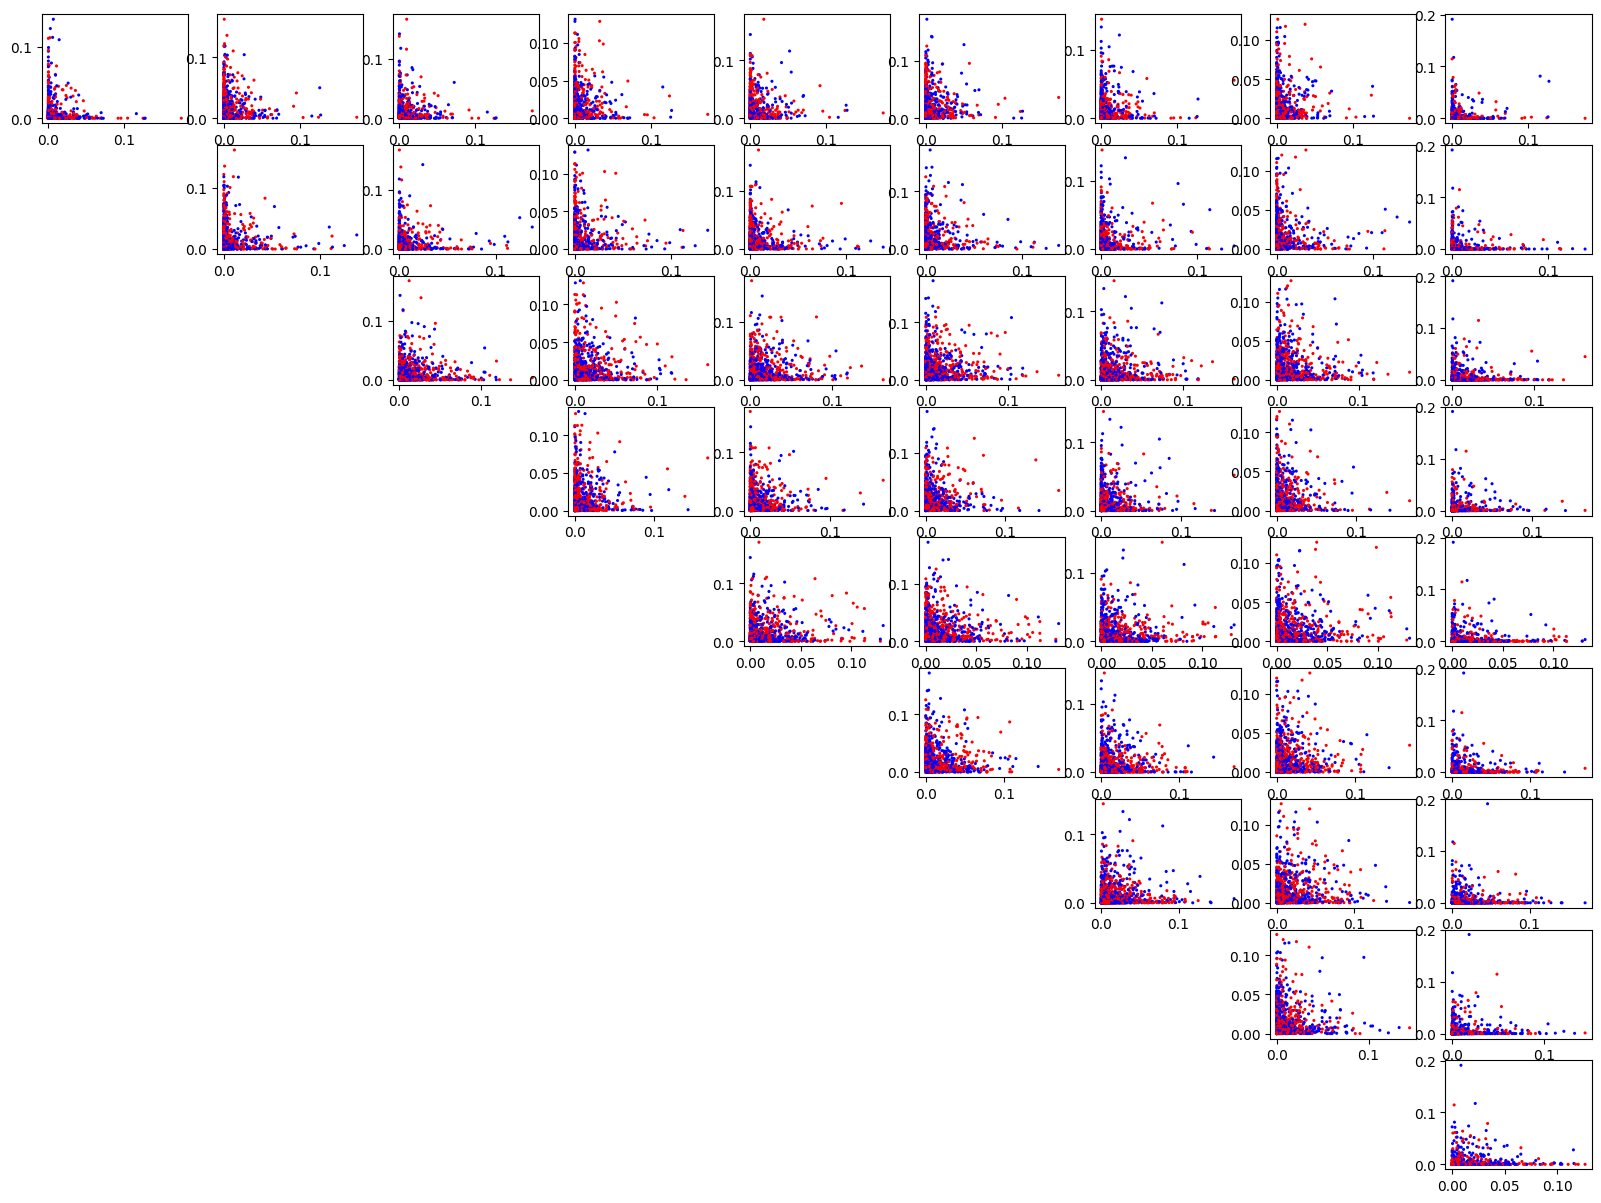

In [28]:
config["data_sample_func"] = "mnd"
config["mnd_M"] = 10000
config["mnd_a1"] = 5
config["mnd_a2"] = 1
config_sample = evaluate_hypers(config)
model = get_model(config_sample, device, should_train=False, verbose=0)
dl = model[3]
plot_grid(dl, config_sample)
plot_feature_combinations(dl, config_sample)

In [21]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
from evaluate import *
from load_models import *
import matplotlib.pyplot as plt
import torch
import openml

In [19]:
from tabpfn import TabPFNClassifier
model = TabPFNClassifier(device='cpu', N_ensemble_configurations=1)
x, y = get_sample(dl)
x, y = torch.squeeze(x), torch.squeeze(y)
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(torch.tensor(preds)*y_test+(torch.tensor(preds)-1)*(y_test-1))

C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
        1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])


In [32]:
for i in range(15):
    x, y = get_sample(dl)
    x, y = torch.squeeze(x), torch.squeeze(y)
    print(torch.mean(y))
    cv = 3
    n_optim = 10
    ft_epochs = 0
    sampling = None
    metrics = metrics = ["accuracy", "precision", "recall", "roc_auc"]
    models = [
        XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'),
        XGBoostOptim(n_optim=n_optim),
        LogisticRegression(max_iter=500), 
        TabPFNClassifier(device='cpu', N_ensemble_configurations=3),
        #TabForestPFNClassifier("saved_models/tabforest/mix600k/tabforestpfn.pt", "saved_models/tabforest/mix600k/config_run.yaml")
    ]
    results = pd.DataFrame(np.zeros((len(models), len(metrics))), 
                           index=[m.__class__.__name__ for m in models],
                          columns=metrics)
    
    for ii, model in enumerate(models):
        results.iloc[ii,:] = cross_validate_sample(model, x, y, metrics, cv, sampling)
    print(results)

tensor(0.5000)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.545546   0.516965  0.575362  0.547540
XGBoostOptim        0.567568   0.540342  0.600544  0.570434
LogisticRegression  0.482482   0.476498  0.881058  0.506819
TabPFNClassifier    0.482482   0.469625  0.698527  0.495303
tensor(0.6050)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.778779   0.794920  0.856222  0.758251
XGBoostOptim        0.710711   0.709564  0.903841  0.661423
LogisticRegression  0.606607   0.606607  1.000000  0.500000
TabPFNClassifier    0.640641   0.642193  0.923055  0.565029
tensor(0.5010)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.520521   0.518930  0.562757  0.521322
XGBoostOptim        0.507508   0.505554  0.525279  0.508466
LogisticRegression  0.511512   0.513573  0.611405  0.514882
TabPFNClassifier    0.496496   0.499042  0.687610  0.499981
tensor(0.5190)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.627628   0.650345  0.643069  0.630447
XGBoostOptim        0.618619   0.626828  0.715257  0.620800
LogisticRegression  0.501502   0.537798  0.682883  0.512613
TabPFNClassifier    0.524525   0.548679  0.722639  0.528517
tensor(0.6820)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.948949   0.945552  0.980545  0.932026
XGBoostOptim        0.936937   0.921517  0.990991  0.907234
LogisticRegression  0.676677   0.676677  1.000000  0.500000
TabPFNClassifier    0.758759   0.772922  0.912900  0.676041
tensor(0.5090)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.494494   0.514270  0.514320  0.493948
XGBoostOptim        0.500501   0.519279  0.571045  0.498629
LogisticRegression  0.529530   0.548038  0.614021  0.529636
TabPFNClassifier    0.547548   0.551391  0.707906  0.541974
tensor(0.5740)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.607608   0.641453  0.716432  0.589642
XGBoostOptim        0.616617   0.624636  0.830192  0.581090
LogisticRegression  0.571572   0.571572  1.000000  0.500000
TabPFNClassifier    0.573574   0.572883  0.998255  0.502649
tensor(0.5550)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.590591   0.620347  0.666131  0.582273
XGBoostOptim        0.589590   0.586403  0.903096  0.552669
LogisticRegression  0.551552   0.551552  1.000000  0.500000
TabPFNClassifier    0.561562   0.565552  0.889610  0.524422
tensor(0.5200)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.520521   0.532703  0.566306  0.519439
XGBoostOptim        0.542543   0.540988  0.783187  0.536569
LogisticRegression  0.510511   0.513022  0.973000  0.496982
TabPFNClassifier    0.514515   0.516853  0.921366  0.503608
tensor(0.5000)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.513514   0.526394  0.520021  0.513531
XGBoostOptim        0.535536   0.547639  0.526703  0.535423
LogisticRegression  0.488488   0.517757  0.338286  0.499127
TabPFNClassifier    0.498498   0.512675  0.554948  0.501284
tensor(0.5020)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.486486   0.484182  0.500316  0.487356
XGBoostOptim        0.463463   0.459634  0.498108  0.465553
LogisticRegression  0.493493   0.495268  0.634488  0.500545
TabPFNClassifier    0.487487   0.492492  0.727811  0.493987
tensor(0.5200)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.842843   0.830125  0.874041  0.841876
XGBoostOptim        0.829830   0.798331  0.896067  0.827506
LogisticRegression  0.541542   0.532661  0.961878  0.530955
TabPFNClassifier    0.627628   0.629052  0.673355  0.626185
tensor(0.5260)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.534535   0.573365  0.563672  0.532012
XGBoostOptim        0.579580   0.582502  0.807902  0.557353
LogisticRegression  0.557558   0.554026  0.960119  0.519898
TabPFNClassifier    0.546547   0.551764  0.888761  0.515049
tensor(0.5010)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.501502   0.505015  0.493865  0.502034
XGBoostOptim        0.545546   0.595760  0.443240  0.554304
LogisticRegression  0.537538   0.543551  0.566172  0.546905
TabPFNClassifier    0.578579   0.573496  0.647472  0.580224
tensor(0.5080)


C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-packages\torch\utils\checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
C:\Users\lenna\anaconda3\envs\master3\Lib\site-pac

                    accuracy  precision    recall   roc_auc
XGBClassifier       0.906907   0.915418  0.902381  0.906568
XGBoostOptim        0.886887   0.917008  0.859921  0.886962
LogisticRegression  0.594595   0.601800  0.706349  0.597480
TabPFNClassifier    0.684685   0.692814  0.699735  0.683973


                    accuracy  precision    recall   roc_auc
XGBClassifier       0.998999   1.000000  0.985507  0.992754
XGBoostOptim        0.936937   0.000000  0.000000  0.500000
LogisticRegression  0.936937   0.000000  0.000000  0.500000
TabPFNClassifier    0.950951   0.904762  0.257971  0.627921


In [12]:
def multinomial_dirichlet(size=(1000,100)):
    M = 1000
    alphas = np.random.beta(1,1,size[1])
    thetas = [np.random.dirichlet(alphas) for i in range(size[0])]
    #print(thetas, np.sum(thetas))
    X = np.asarray([np.random.multinomial(M, theta)/M for theta in thetas])
    return X
X = multinomial_dirichlet()
print(X[:3])

[[0.008 0.002 0.    0.006 0.    0.001 0.012 0.001 0.034 0.004 0.01  0.
  0.02  0.027 0.    0.    0.001 0.029 0.    0.01  0.005 0.005 0.001 0.005
  0.009 0.005 0.007 0.009 0.009 0.    0.001 0.003 0.    0.007 0.023 0.001
  0.    0.003 0.002 0.054 0.006 0.074 0.    0.    0.002 0.004 0.    0.034
  0.005 0.009 0.    0.    0.001 0.    0.05  0.    0.001 0.016 0.014 0.02
  0.    0.012 0.    0.005 0.    0.    0.006 0.017 0.01  0.    0.018 0.038
  0.028 0.    0.006 0.    0.    0.033 0.001 0.    0.009 0.    0.    0.034
  0.002 0.033 0.021 0.024 0.    0.018 0.007 0.075 0.    0.005 0.023 0.
  0.015 0.002 0.    0.008]
 [0.008 0.009 0.    0.    0.    0.006 0.024 0.005 0.022 0.02  0.    0.018
  0.048 0.022 0.001 0.    0.021 0.    0.    0.011 0.    0.067 0.011 0.
  0.003 0.    0.    0.011 0.009 0.    0.    0.007 0.    0.012 0.003 0.01
  0.    0.01  0.    0.005 0.021 0.058 0.    0.    0.    0.011 0.    0.003
  0.021 0.002 0.    0.003 0.    0.004 0.045 0.002 0.    0.005 0.006 0.
  0.021 0.003 0.    0.015

In [13]:
'''def get_sample(config_sample, prior_hyperparameters):
    def eval_pos_seq_len_sampler():
        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get('max_eval_pos', config['bptt']), min_len=config.get('min_eval_pos', 0))
        single_eval_pos = single_eval_pos_gen()
        return single_eval_pos, 1024
    ''extra_prior_kwargs_dict={
        'num_features': config['num_features'], 
        'hyperparameters': prior_hyperparameters
    }
    extra_kwargs = {}
    if 'flexible' in config and config['flexible']:
        get_batch_base = make_get_batch(model_proto)
        extra_kwargs['get_batch'] = get_batch_base
        model_proto = priors.flexible_categorical
    if 'differentiable' in prior_hyperparameters and prior_hyperparameters['differentiable']:
        get_batch_base = make_get_batch(model_proto, **extra_kwargs)
        extra_kwargs = {'get_batch': get_batch_base, 'differentiable_hyperparameters': prior_hyperparameters['differentiable_hyperparameters']}
        model_proto = priors.differentiable_prior
        use_style = True
    
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_prior_kwargs_dict)''
    dl_class, extra_kwargs = get_dataloader(config_sample, device="cpu", should_train=False, verbose=2)
    dl = model_proto.DataLoader(num_steps=1, batch_size=1, 
                                eval_pos_seq_len_sampler=eval_pos_seq_len_sampler, 
                                seq_len_maximum=None, device="cpu", **extra_kwargs)
    dl.model = None
    return next(iter(dl))'''

'def get_sample(config_sample, prior_hyperparameters):\n    def eval_pos_seq_len_sampler():\n        single_eval_pos_gen = get_uniform_single_eval_pos_sampler(config.get(\'max_eval_pos\', config[\'bptt\']), min_len=config.get(\'min_eval_pos\', 0))\n        single_eval_pos = single_eval_pos_gen()\n        return single_eval_pos, 1024\n    \'\'extra_prior_kwargs_dict={\n        \'num_features\': config[\'num_features\'], \n        \'hyperparameters\': prior_hyperparameters\n    }\n    extra_kwargs = {}\n    if \'flexible\' in config and config[\'flexible\']:\n        get_batch_base = make_get_batch(model_proto)\n        extra_kwargs[\'get_batch\'] = get_batch_base\n        model_proto = priors.flexible_categorical\n    if \'differentiable\' in prior_hyperparameters and prior_hyperparameters[\'differentiable\']:\n        get_batch_base = make_get_batch(model_proto, **extra_kwargs)\n        extra_kwargs = {\'get_batch\': get_batch_base, \'differentiable_hyperparameters\': prior_hyperparame

In [14]:
a = get_sample(config_sample, prior_hyperparameters)
print(a[0][1].shape)

NameError: name 'prior_hyperparameters' is not defined

In [ ]:
config['differentiable'] = False
config['flexible'] = False

# forest params
config["min_features"] = 10
config["max_features"] = 100
config["n_samples"] = 1000
config["max_classes"] = 10
config["base_size"] = 1000
config["n_estimators"] = 1
config["min_depth"] = 1
config["max_depth"] = 25
config["categorical_x"] = False

In [ ]:
from xgboost import XGBClassifier
import warnings
from tabpfn import TabPFNClassifier
import numpy as np
import pandas as pd
import os
from evaluate import scores
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from data_prep_utils import *
import matplotlib.pyplot as plt
import torch
import openml
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest

In [ ]:
from tabularbench.data.synthetic_generator_tabpfn import synthetic_dataset_generator_tabpfn

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_tabpfn(n_samples=1000, max_classes=2, min_features=2, max_features=100)

for ax in axes.flatten():
    x2, b = next(generator)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    ax.scatter(x2[:, i1], x2[:, i2], c=b)

In [ ]:
from tabularbench.data.synthetic_generator_forest import synthetic_dataset_generator_forest, synthetic_dataset_function_forest
import matplotlib

fig, axes = plt.subplots(8, 6, figsize=(20, 15))
generator = synthetic_dataset_generator_forest(n_samples=1000, max_classes=2, min_features=2, max_features=2)

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))

for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:
def zinb(size=(1000,100)):
    pi = 0.25
    p = np.random.uniform(0.1,0.9, size=size[1])
    p = np.repeat(np.expand_dims(p,axis=0),size[0],axis=0)
    #print
    #p += 1e-5
    X = np.random.negative_binomial(100,p)
    X = np.random.binomial(1,1-pi,size)*X
    return X

In [ ]:
def zinb_comp(size=(1000,100)):
    X =  zinb(size)
    print(X)
    print(np.expand_dims(1/np.sum(X,axis=1),axis=1))
    return np.expand_dims(1/np.sum(X,axis=1),axis=1)*X

In [ ]:
out = zinb_comp((10,10))
print(out)

In [ ]:
print(np.sum(out, axis=1))

In [ ]:
from prior.synthetic_generator_forest_altdata import synthetic_dataset_generator_forest_altdata, synthetic_dataset_function_forest_altdata

fig, axes = plt.subplots(8, 6, figsize=(20, 15))

cmap = matplotlib.colormaps['inferno']
colors = cmap(np.linspace(0.0, 0.9, 10))



for ax in axes.flatten():
    x2, b = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    i1, i2 = np.random.choice(x2.shape[1], size=(2,), replace=False)
    random_shuffle = np.random.permutation(np.arange(10))
    colors_shuffle = colors[random_shuffle]
    #b = np.array([colors_shuffle[i] for i in b])
    ax.scatter(x2[:, i1], x2[:, i2], c=b)
    ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

fig.tight_layout()

In [ ]:

X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    X_norm, b_norm = synthetic_dataset_function_forest(base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_norm, b_norm, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
accuracy = np.zeros((3))
runs = 10
for ii in range(runs):
    print(ii)
    X_zinb, b_zinb = synthetic_dataset_function_forest_altdata(zinb,base_size=1000, min_features=2, max_features=2, max_classes=3, min_depth=1, max_depth=25, categorical_x=True, n_samples=1024)
    models = [XGBClassifier(n_estimators=5, max_depth=5, learning_rate=1, objective='binary:logistic'), 
              LogisticRegression(max_iter=500), 
              TabPFNClassifier(device='cpu', N_ensemble_configurations=3)]
    X_train, X_test, y_train, y_test = train_test_split(X_zinb, b_zinb, test_size=0.2, random_state=42)
    for mm, model in enumerate(models):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy[mm] += accuracy_score(y_test,y_pred)
print(accuracy/runs)